In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import Dataset , DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer

os.system('pip install pycm')
os.system('pip install -U nltk')
os.system('python -m nltk.downloader all')
os.system('pip install transformers')

import pycm
from nltk.tokenize import word_tokenize
from torchtext.vocab import GloVe
from transformers import AutoTokenizer
from transformers import AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
class MSCTDDataset(Dataset):
    def __init__(self, img_dir, mode , transform=None, target_transform=None,resize = None):
        # downloading text files from github
        print('\nLoading Text Files')
        os.system('git clone https://github.com/XL2248/MSCTD.git')
        #unziping images
        if mode == 'train':
          print('Loading Train Images')
          os.system('unzip -n '+ os.path.join(img_dir,'train_ende.zip'))
          os.system('mv train_ende train')
          print('Train Images Count:', len(os.listdir('train')))
          os.system('cp -r MSCTD/MSCTD_data/ende/english_train.txt -t train')
          os.system('cp -r MSCTD/MSCTD_data/ende/image_index_train.txt -t train')
          os.system('cp -r MSCTD/MSCTD_data/ende/sentiment_train.txt -t train')
        

        if mode == 'dev':
          print('Loading Validation Images')
          os.system('unzip -n '+ os.path.join(img_dir,'dev.zip'))
          print('Dev Images Count:', len(os.listdir('dev')))
          os.system('cp -r MSCTD/MSCTD_data/ende/english_dev.txt -t dev')
          os.system('cp -r MSCTD/MSCTD_data/ende/image_index_dev.txt -t dev')
          os.system('cp -r MSCTD/MSCTD_data/ende/sentiment_dev.txt -t dev')
        

        if mode == 'test':
          print('Loading Test Images')
          os.system('unzip -n '+ os.path.join(img_dir,'test.zip'))
          print('Test Images Count:', len(os.listdir('test')))
          os.system('cp -r MSCTD/MSCTD_data/ende/english_test.txt -t test')
          os.system('cp -r MSCTD/MSCTD_data/ende/image_index_test.txt -t test')
          os.system('cp -r MSCTD/MSCTD_data/ende/sentiment_test.txt -t test')

        os.system('rm -r MSCTD')
        # processing text files and saving them as attribute of dataset
        if mode == 'val':
            mode = 'dev'
        file1 = open(mode + '/sentiment_' + mode + '.txt', 'r')
        Lines = file1.readlines()
        file1.close()
        label = []
        for line in Lines:
            line = line.strip()
            label.append(int(line))         
        self.sentiment = np.array(label)

        file1 = open(mode + '/english_' + mode + '.txt', 'r')
        Lines = file1.readlines()
        file1.close()
        text = []
        for line in Lines:
            line = line.strip()
            text.append(line)  
        self.text = text

        image_index = []
        file1 = open(mode + '/image_index_' + mode + '.txt', 'r')
        Lines = file1.readlines()
        file1.close()
        text = []
        for line in Lines:
            line = line.strip()
            image_index.append(line) 
        self.image_index = image_index

        self.mode = mode
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.resize = resize
        
    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):
        img_path = os.path.join(self.mode, f'{idx}.jpg')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
        sentiment = self.sentiment[idx]
        text = self.text[idx]
        if self.resize:
              image = cv2.resize(image, self.resize) 
        else :
              image = cv2.resize(image, (1280,633)) 

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            sentiment = self.target_transform(sentiment)
        return {'text':text ,'image':image, 'sentiment':(sentiment)}

In [4]:
train_data = MSCTDDataset(img_dir = '/content/drive/MyDrive/Project/Phase0', mode = 'train', resize = (640,316))
val_data = MSCTDDataset(img_dir = '/content/drive/MyDrive/Project/Phase0', mode = 'dev', resize = (640,316))
test_data = MSCTDDataset(img_dir = '/content/drive/MyDrive/Project/Phase0', mode = 'test',  resize = (640,316))


Loading Text Files
Loading Train Images
Train Images Count: 20240

Loading Text Files
Loading Validation Images
Dev Images Count: 5063

Loading Text Files
Loading Test Images
Test Images Count: 5067


In [5]:
train_text = train_data.text
train_sentiment = train_data.sentiment
val_text =val_data.text
val_sentiment = val_data.sentiment
test_text = test_data.text
test_sentiment = test_data.sentiment

In [6]:
y_train = torch.tensor(train_sentiment)
y_val = torch.tensor(val_sentiment)
y_test = torch.tensor(test_sentiment)

In [ ]:
train_text_clean=[]
for i,line in enumerate(train_text):
    words = word_tokenize(line)
    clean_text = [word for word in words if word.isalpha()]
    train_text_clean.append(clean_text)
  

In [ ]:
val_text_clean=[]
for i,line in enumerate(val_text):
    words = word_tokenize(line)
    clean_text = [word for word in words if word.isalpha()]
    val_text_clean.append(clean_text)

In [ ]:
test_text_clean=[]
for i,line in enumerate(test_text):
    words = word_tokenize(line)
    clean_text = [word for word in words if word.isalpha()]
    test_text_clean.append(clean_text)

# Part1

In [21]:
# Defining the Neural Network Layers, Neurons and Activation Function
class NNtfid(nn.Module):
    def __init__(self, p, dim):
        self.p = p
        self.dim = dim
        super(NNtfid, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(self.dim, 64),
                      nn.ReLU(),
                      nn.Dropout(p),
                      nn.Linear(64, 3),
            )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [22]:
vectorizer = TfidfVectorizer()

# Learn vocabulary from training texts and vectorize training texts.
x_train = vectorizer.fit_transform(train_text)

# Vectorize test texts.
x_val = vectorizer.transform(val_text)
x_test = vectorizer.transform(test_text)

In [ ]:
len(vectorizer.get_feature_names_out())

9558

In [23]:
x_train = torch.tensor(scipy.sparse.csr_matrix.todense(x_train)).float()
x_val = torch.tensor(scipy.sparse.csr_matrix.todense(x_val)).float()
x_test = torch.tensor(scipy.sparse.csr_matrix.todense(x_test)).float()

In [ ]:
train_text[2]

"I'm sorry. I have to tell you something,"

In [ ]:
x_train[2].count_nonzero()

tensor(6)

In [24]:
def train_loop(x_train,y_train, model, loss_fn, optimizer):
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    train_loss, correct = 0, 0
    optimizer.zero_grad()

    pred = model.forward(x_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    train_loss = loss.item()
    correct += (pred.argmax(1) == y_train).type(torch.float).sum().item()

    optimizer.step()

    
    return 100*correct/len(x_train), train_loss

# Defining the function that will do calculation of Loss and Accuracy over Test Dataset
def Accuracy_Loss(x,y, model, loss_fn):
    x_test = x.to(device)
    y_test = y.to(device)
   

    with torch.no_grad():
        pred = model(x_test)
        test_loss = loss_fn(pred, y_test).item()


        y_pred = pred.argmax(1)

        correct = (pred.argmax(1) == y_test).type(torch.float).sum().item()
        
   
        

    
    return 100*correct/len(x_test), test_loss

In [25]:
learning_rate = 1e-3
batch_size = 128
epochs = 200
loss_fn = nn.CrossEntropyLoss()

# model and optimizer defenintion
model = NNtfid(p=0.5,dim = x_train.shape[1]).to(device)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# lists to save loss and accuracy
train_loss_model = []
val_loss_model = []
train_acu_model = []
val_acu_model = []

best_acu = 0
for e in range(epochs):
    
    print(f'epoch {e+1}/{epochs}:')
    
    model.train()
    t_loss = train_loop(x_train,y_train, model, loss_fn, optimizer)
    train_loss_model.append(t_loss[1]),train_acu_model.append(t_loss[0])

    model.eval()

   
    v_loss =  Accuracy_Loss(x_val,y_val, model, loss_fn)
    val_loss_model.append(v_loss[1]),val_acu_model.append(v_loss[0])

    print(f'train loss:{t_loss[1]:0.4f}    train acc:{t_loss[0]:0.3f} ---- val loss:{v_loss[1]:0.4f}   val acc:{v_loss[0]:0.3f} \n')
    if val_acu_model[e]>best_acu:
        best_acu = val_acu_model[e]
        torch.save(model, 'model.pth')
        best_epoch = e+1
        
best_model = torch.load('model.pth')
best_model.eval()
print(f"model result for epoch {best_epoch}:")
print("Best Model Accuracy for Train Set:", train_acu_model[best_epoch-1])  
print("Best Model Accuracy for Validation Set:",val_acu_model[best_epoch-1]) 
print("Best Model Accuracy for Test Set:",Accuracy_Loss(x_test,y_test, best_model, loss_fn)[0])    

torch.save(best_model, '/content/drive/MyDrive/Project/Phase2/model_tmp.pth')

epoch 1/200:
train loss:1.1042    train acc:27.090 ---- val loss:1.1026   val acc:28.600 

epoch 2/200:
train loss:1.1028    train acc:27.090 ---- val loss:1.1019   val acc:28.600 

epoch 3/200:
train loss:1.1014    train acc:27.090 ---- val loss:1.1011   val acc:28.600 

epoch 4/200:
train loss:1.1001    train acc:27.095 ---- val loss:1.1002   val acc:28.600 

epoch 5/200:
train loss:1.0986    train acc:27.525 ---- val loss:1.0993   val acc:28.817 

epoch 6/200:
train loss:1.0970    train acc:30.227 ---- val loss:1.0984   val acc:33.004 

epoch 7/200:
train loss:1.0954    train acc:35.371 ---- val loss:1.0974   val acc:38.297 

epoch 8/200:
train loss:1.0936    train acc:41.492 ---- val loss:1.0964   val acc:42.445 

epoch 9/200:
train loss:1.0917    train acc:46.285 ---- val loss:1.0953   val acc:43.334 

epoch 10/200:
train loss:1.0898    train acc:48.849 ---- val loss:1.0942   val acc:43.512 

epoch 11/200:
train loss:1.0876    train acc:49.822 ---- val loss:1.0931   val acc:43.433

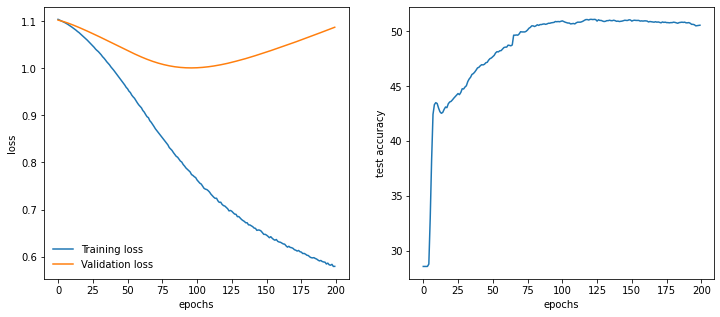

In [26]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(train_loss_model, label='Training loss')
plt.plot(val_loss_model, label='Validation loss')
plt.legend(frameon=False);
plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.plot(val_acu_model);

Overall Statistics : 

ACC Macro                                                         0.67607
F1 Macro                                                          0.49626
FPR Macro                                                         0.24652
Kappa                                                             0.25538
Overall ACC                                                       0.51411
PPV Macro                                                         0.50605
SOA1(Landis & Koch)                                               Fair
TPR Macro                                                         0.49784
Zero-one Loss                                                     2462

Class Statistics :

Classes                                                           0             1             2             
ACC(Accuracy)                                                     0.66588       0.6568        0.70555       
AUC(Area under the ROC curve)                                     0.60039     

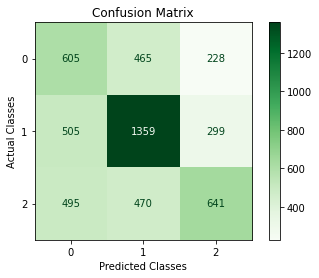

In [ ]:
best_model = torch.load('/content/drive/MyDrive/Project/Phase2/model.pth')
best_model.eval()
pred = best_model(x_test.to(device))

y_pred = pred.argmax(1).tolist()

y_actu = y_test.tolist()
cm = pycm.ConfusionMatrix(actual_vector=y_actu, predict_vector=y_pred)
cm.plot(cmap=plt.cm.Greens, number_label=True, plot_lib="matplotlib")
cm.stat(summary=True)

# Part 3

In [27]:
# Defining the Neural Network Layers, Neurons and Activation Function
class NNglove(nn.Module):
    def __init__(self, dim):
        
        self.dim = dim
        super(NNglove, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
                        nn.Linear(self.dim, 128),
                       nn.BatchNorm1d(128),                      
                                     
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(128, 32),
                      nn.BatchNorm1d(32),                      
                      nn.ReLU(),
                      
                      nn.Dropout(0.5),
                      nn.Linear(32, 8),
                      nn.BatchNorm1d(8),                      
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(8, 3),
            )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [28]:
global_vectors = GloVe(name='6B', dim=50)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 399999/400000 [00:10<00:00, 39281.80it/s]


In [29]:
glove_train =[]
max_words = 25
embeded_len = 50
X_tensor_train = torch.zeros(len(train_text), max_words*embeded_len )
for i,line in enumerate(train_text):
    words = word_tokenize(line)
    words = [word for word in words if word.isalpha()]
    words = words + [""] * (max_words-len(words))
    tensor = global_vectors.get_vecs_by_tokens(words)
    X_tensor_train[i] = (tensor.reshape(1, -1))


In [30]:
X_tensor_val = torch.zeros(len(val_text), max_words*embeded_len )
for i,line in enumerate(val_text):
    words = word_tokenize(line)
    words = [word for word in words if word.isalpha()]
    words = words + [""] * (max_words-len(words))
    tensor = global_vectors.get_vecs_by_tokens(words)
    X_tensor_val[i] = (tensor.reshape(1, -1))

In [31]:
X_tensor_test = torch.zeros(len(test_text), max_words*embeded_len )
for i,line in enumerate(test_text):
    words = word_tokenize(line)
    words = [word for word in words if word.isalpha()]
    words = words + [""] * (max_words-len(words))
    tensor = global_vectors.get_vecs_by_tokens(words)
    X_tensor_test[i] = (tensor.reshape(1, -1))

In [34]:
learning_rate = 1e-3
batch_size = 128
epochs = 400
loss_fn = nn.CrossEntropyLoss()

# model and optimizer defenintion
model3 = NNglove(X_tensor_train.shape[1]).to(device)

model3.train()
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

# lists to save loss and accuracy
train_loss_model = []
val_loss_model = []
train_acu_model = []
val_acu_model = []

best_acu = 0
for e in range(epochs):
    
    print(f'epoch {e+1}/{epochs}:')
    
    model3.train()
    t_loss = train_loop(X_tensor_train,y_train, model3, loss_fn, optimizer)
    train_loss_model.append(t_loss[1]),train_acu_model.append(t_loss[0])

    model3.eval()

   
    v_loss =  Accuracy_Loss(X_tensor_val,y_val, model3, loss_fn)
    val_loss_model.append(v_loss[1]),val_acu_model.append(v_loss[0])

    print(f'train loss:{t_loss[1]:0.4f}    train acc:{t_loss[0]:0.3f} ---- val loss:{v_loss[1]:0.4f}   val acc:{v_loss[0]:0.3f} \n')
    if val_acu_model[e]>best_acu:
        best_acu = val_acu_model[e]
        torch.save(model3, 'model3.pth')
        best_epoch = e+1
        
best_model3 = torch.load('model3.pth')
best_model3.eval()
print(f"model result for epoch {best_epoch}:")
print("Best Model Accuracy for Train Set:", train_acu_model[best_epoch-1])  
print("Best Model Accuracy for Validation Set:",val_acu_model[best_epoch-1]) 
print("Best Model Accuracy for Test Set:",Accuracy_Loss(X_tensor_test,y_test, best_model3, loss_fn)[0])    

torch.save(best_model3, '/content/drive/MyDrive/Project/Phase2/model3_tmp.pth')

epoch 1/400:
train loss:1.1461    train acc:36.700 ---- val loss:1.1106   val acc:36.303 

epoch 2/400:
train loss:1.1271    train acc:38.310 ---- val loss:1.1104   val acc:36.303 

epoch 3/400:
train loss:1.1157    train acc:39.343 ---- val loss:1.1099   val acc:36.303 

epoch 4/400:
train loss:1.1119    train acc:39.664 ---- val loss:1.1093   val acc:36.303 

epoch 5/400:
train loss:1.1072    train acc:40.469 ---- val loss:1.1087   val acc:36.303 

epoch 6/400:
train loss:1.1022    train acc:40.326 ---- val loss:1.1078   val acc:36.303 

epoch 7/400:
train loss:1.0998    train acc:41.117 ---- val loss:1.1069   val acc:36.303 

epoch 8/400:
train loss:1.0936    train acc:40.583 ---- val loss:1.1059   val acc:36.303 

epoch 9/400:
train loss:1.0975    train acc:41.433 ---- val loss:1.1049   val acc:36.303 

epoch 10/400:
train loss:1.0895    train acc:41.324 ---- val loss:1.1039   val acc:36.303 

epoch 11/400:
train loss:1.0880    train acc:41.581 ---- val loss:1.1029   val acc:36.303

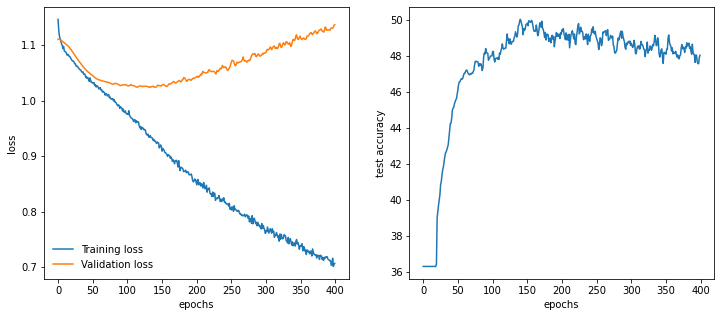

In [35]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(train_loss_model, label='Training loss')
plt.plot(val_loss_model, label='Validation loss')
plt.legend(frameon=False);
plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.plot(val_acu_model);

Overall Statistics : 

ACC Macro                                                         0.65805
F1 Macro                                                          0.47891
FPR Macro                                                         0.25635
Kappa                                                             0.22614
Overall ACC                                                       0.48707
PPV Macro                                                         0.4894
SOA1(Landis & Koch)                                               Fair
TPR Macro                                                         0.48558
Zero-one Loss                                                     2599

Class Statistics :

Classes                                                           0             1             2             
ACC(Accuracy)                                                     0.64772       0.6345        0.69193       
AUC(Area under the ROC curve)                                     0.61192      

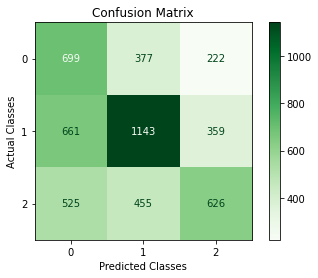

In [ ]:
best_model = torch.load('/content/drive/MyDrive/Project/Phase2/model3.pth')
best_model.eval()
pred = best_model(X_tensor_test.to(device))

y_pred = pred.argmax(1).tolist()

y_actu = y_test.tolist()
cm = pycm.ConfusionMatrix(actual_vector=y_actu, predict_vector=y_pred)
cm.plot(cmap=plt.cm.Greens, number_label=True, plot_lib="matplotlib")
cm.stat(summary=True)

# Part 4

In [7]:
bert_model = "google/bert_uncased_L-12_H-768_A-12" #"google/bert_uncased_L-2_H-128_A-2" "google/bert_uncased_L-4_H-512_A-8" 
tokenizer = AutoTokenizer.from_pretrained(bert_model)

train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=32)
val_encodings = tokenizer(val_text, truncation=True, padding=True, max_length=32)
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=32)

In [8]:
class BertClassifier(nn.Module):
    def __init__(self, p = 0.5):
        self.p = p
        super(BertClassifier, self).__init__()

        self.bert = AutoModel.from_pretrained(bert_model)
        self.linear_relu_stack = nn.Sequential(
            nn.Dropout(p=self.p),
            nn.Linear(768, 3),
            nn.ReLU(),
            )
        
    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        final_layer = self.linear_relu_stack(pooled_output)
        return final_layer
#########################################################################################################

class sentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        X = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        y = self.labels[idx]
        return X, y

    def __len__(self):
        return len(self.labels)

In [9]:
def train(model, train_data, val_data, learning_rate, epochs):
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=128)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

    model = model.to(device)
    loss_fn = loss_fn.to(device)

    train_loss_bert = []
    val_loss_bert = []
    train_acu_bert = []
    val_acu_bert = []

    best_acu = 0
    for e in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            model.train()

            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                batch_loss = loss_fn(output, train_label.long())
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_loss_train += batch_loss.item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            train_loss_bert.append(total_loss_train)
            train_acu_bert.append(total_acc_train * 100 / len(train_data))
            total_acc_val = 0
            total_loss_val = 0
            model.eval()

            with torch.no_grad():

                for val_input, val_label in val_dataloader:
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                    batch_loss = loss_fn(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            val_loss_bert.append(total_loss_val)
            val_acu_bert.append(total_acc_val * 100 / len(val_data))

            if val_acu_bert[e]>best_acu:
              best_acu = val_acu_bert[e]
              torch.save(model, 'Bert_model.pth')
              best_epoch = e+1

            print(
                f'Epochs: {e + 1} | Train Loss: {total_loss_train / len(train_data): .5f} \
                | Train Accuracy: {total_acc_train * 100 / len(train_data): .2f}% \
                | Val Loss: {total_loss_val / len(val_data): .5f} \
                | Val Accuracy: {total_acc_val * 100 / len(val_data): .2f}%')
                  
    return model, best_epoch, train_loss_bert, train_acu_bert, val_loss_bert, val_acu_bert
##############################################################################################################

def evaluate(model, test_data):
    test_dataloader = DataLoader(test_data, batch_size=128)
    model = model.to(device)
    total_acc_test = 0

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    return total_acc_test * 100  / len(test_data)

## Fine Tuning Bert

In [ ]:
train_dataset = sentDataset(train_encodings, y_train)
val_dataset = sentDataset(val_encodings, y_val)
test_dataset = sentDataset(test_encodings, y_test)

epochs = 20
model = BertClassifier()
learning_rate = 1e-6

result = train(model, train_dataset, val_dataset, learning_rate, epochs)             
best_bert_model, best_epoch, train_loss_bert, train_acu_bert, val_loss_bert, val_acu_bert = result
torch.save(best_bert_model, '/content/drive/MyDrive/Project/Phase2/Bert_model2.pth')     
Bert_model = torch.load("/content/drive/MyDrive/Project/Phase2/Bert_model2.pth")

print(f"Bert result for epoch {best_epoch}:")
print("Best Model Accuracy for Train Set:", train_acu_bert[best_epoch-1])  
print("Best Model Accuracy for Validation Set:",val_acu_bert[best_epoch-1])    
print("Best Model Accuracy for Test Set:", evaluate(Bert_model, test_dataset))  

100%|██████████| 159/159 [01:32<00:00,  1.73it/s]


Epochs: 1 | Train Loss:  0.00865                 | Train Accuracy:  36.90%                 | Val Loss:  0.00854                 | Val Accuracy:  41.08%


100%|██████████| 159/159 [01:32<00:00,  1.73it/s]


Epochs: 2 | Train Loss:  0.00843                 | Train Accuracy:  42.74%                 | Val Loss:  0.00836                 | Val Accuracy:  44.10%


100%|██████████| 159/159 [01:32<00:00,  1.71it/s]


Epochs: 3 | Train Loss:  0.00819                 | Train Accuracy:  46.84%                 | Val Loss:  0.00810                 | Val Accuracy:  46.95%


100%|██████████| 159/159 [01:33<00:00,  1.71it/s]


Epochs: 4 | Train Loss:  0.00790                 | Train Accuracy:  50.82%                 | Val Loss:  0.00779                 | Val Accuracy:  52.24%


100%|██████████| 159/159 [01:33<00:00,  1.70it/s]


Epochs: 5 | Train Loss:  0.00751                 | Train Accuracy:  55.78%                 | Val Loss:  0.00747                 | Val Accuracy:  57.34%


100%|██████████| 159/159 [01:34<00:00,  1.69it/s]


Epochs: 6 | Train Loss:  0.00718                 | Train Accuracy:  58.68%                 | Val Loss:  0.00725                 | Val Accuracy:  58.33%


100%|██████████| 159/159 [01:33<00:00,  1.70it/s]


Epochs: 7 | Train Loss:  0.00700                 | Train Accuracy:  60.44%                 | Val Loss:  0.00715                 | Val Accuracy:  58.56%


100%|██████████| 159/159 [01:33<00:00,  1.70it/s]


Epochs: 8 | Train Loss:  0.00683                 | Train Accuracy:  61.84%                 | Val Loss:  0.00704                 | Val Accuracy:  59.65%


100%|██████████| 159/159 [01:33<00:00,  1.70it/s]


Epochs: 9 | Train Loss:  0.00674                 | Train Accuracy:  62.54%                 | Val Loss:  0.00700                 | Val Accuracy:  59.83%


100%|██████████| 159/159 [01:33<00:00,  1.71it/s]


Epochs: 10 | Train Loss:  0.00661                 | Train Accuracy:  63.59%                 | Val Loss:  0.00698                 | Val Accuracy:  60.34%


100%|██████████| 159/159 [01:33<00:00,  1.71it/s]


Epochs: 11 | Train Loss:  0.00653                 | Train Accuracy:  63.98%                 | Val Loss:  0.00693                 | Val Accuracy:  60.56%


100%|██████████| 159/159 [01:33<00:00,  1.70it/s]


Epochs: 12 | Train Loss:  0.00647                 | Train Accuracy:  64.30%                 | Val Loss:  0.00693                 | Val Accuracy:  60.71%


100%|██████████| 159/159 [01:33<00:00,  1.70it/s]


Epochs: 13 | Train Loss:  0.00642                 | Train Accuracy:  64.82%                 | Val Loss:  0.00688                 | Val Accuracy:  60.97%


100%|██████████| 159/159 [01:33<00:00,  1.70it/s]


Epochs: 14 | Train Loss:  0.00637                 | Train Accuracy:  65.31%                 | Val Loss:  0.00691                 | Val Accuracy:  60.97%


100%|██████████| 159/159 [01:34<00:00,  1.69it/s]


Epochs: 15 | Train Loss:  0.00628                 | Train Accuracy:  66.16%                 | Val Loss:  0.00689                 | Val Accuracy:  61.37%


100%|██████████| 159/159 [01:34<00:00,  1.69it/s]


Epochs: 16 | Train Loss:  0.00623                 | Train Accuracy:  65.96%                 | Val Loss:  0.00688                 | Val Accuracy:  61.29%


100%|██████████| 159/159 [01:33<00:00,  1.69it/s]


Epochs: 17 | Train Loss:  0.00616                 | Train Accuracy:  66.43%                 | Val Loss:  0.00691                 | Val Accuracy:  61.09%


100%|██████████| 159/159 [01:33<00:00,  1.69it/s]


Epochs: 18 | Train Loss:  0.00612                 | Train Accuracy:  66.81%                 | Val Loss:  0.00692                 | Val Accuracy:  61.15%


100%|██████████| 159/159 [01:34<00:00,  1.69it/s]


Epochs: 19 | Train Loss:  0.00607                 | Train Accuracy:  67.52%                 | Val Loss:  0.00691                 | Val Accuracy:  61.29%


100%|██████████| 159/159 [01:33<00:00,  1.70it/s]


Epochs: 20 | Train Loss:  0.00601                 | Train Accuracy:  67.73%                 | Val Loss:  0.00689                 | Val Accuracy:  61.56%
Bert result for epoch 20:
Best Model Accuracy for Train Set: 67.73221343873517
Best Model Accuracy for Validation Set: 61.564289946671934
Best Model Accuracy for Test Set: 62.20643378725084


In [10]:
tokenizer = AutoTokenizer.from_pretrained(bert_model)



In [ ]:
test_set = {key: torch.tensor(val[:]) for key, val in test_encodings.items()}


In [11]:
best_model = torch.load('/content/drive/MyDrive/Project/Phase2/Bert_model.pth')
best_model.eval()
#test_dataloader = DataLoader(test_dataset, batch_size=128)
best_model = best_model.to(device)
output=[]

for text in test_text:
    test_encodings = tokenizer(text, truncation=True, padding=True, max_length=32)
    test_set = {key: torch.tensor(val[:]) for key, val in test_encodings.items()}
    mask = test_set['attention_mask'].to(device)

    input_id = test_set['input_ids'].to(device)
    #print(mask.shape,input_id.shape)
    output.append(best_model(input_id.reshape(1,mask.shape[0]), mask.reshape(1,input_id.shape[0])).argmax(dim=1).cpu().item())


In [20]:
test_encodings = tokenizer(text, truncation=True, padding=True, max_length=32)
test_set = {key: torch.tensor(val[:]) for key, val in test_encodings.items()}
mask = test_set['attention_mask'].to(device)
print(mask.reshape(1,mask.shape[0]).shape)

torch.Size([9])


Overall Statistics : 

ACC Macro                                                         0.75686
F1 Macro                                                          0.62403
FPR Macro                                                         0.18182
Kappa                                                             0.44546
Overall ACC                                                       0.63529
PPV Macro                                                         0.62895
SOA1(Landis & Koch)                                               Moderate
TPR Macro                                                         0.62668
Zero-one Loss                                                     1848

Class Statistics :

Classes                                                           0             1             2             
ACC(Accuracy)                                                     0.73535       0.75903       0.7762        
AUC(Area under the ROC curve)                                     0.69457 

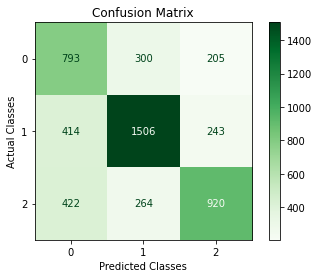

In [12]:
y_actu = y_test.tolist()
cm = pycm.ConfusionMatrix(actual_vector=y_actu, predict_vector=output)
cm.plot(cmap=plt.cm.Greens, number_label=True, plot_lib="matplotlib")
cm.stat(summary=True)